In [46]:
# !pip install -q huggingface_hub pandas pyarrow

from huggingface_hub import list_repo_files, hf_hub_download
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# OneStopEnglish 

In [47]:
REPO = "iastate/onestop_english"

# 2) List files in the dataset repo  (NOTE repo_type="dataset")
files = list_repo_files(REPO, repo_type="dataset")
print("Files in repo:", files[:20])  # peek

# 3) Pick a parquet/csv file
cands = [f for f in files if f.lower().endswith((".parquet", ".csv"))]
assert cands, "No parquet/csv found in repo listing."
fname = cands[0]
print("Using:", fname)

# 4) Download the file (NOTE repo_type="dataset")
local_path = hf_hub_download(repo_id=REPO, filename=fname, repo_type="dataset")
print("Downloaded to:", local_path)

# 5) Load to pandas
if fname.lower().endswith(".parquet"):
    df = pd.read_parquet(local_path)
else:
    df = pd.read_csv(local_path)

print(df.head())
print(df.columns.tolist())


# Map numeric labels → text levels
label2level = {0: "elementary", 1: "intermediate", 2: "advanced"}
df["level"] = df["label"].map(label2level)

# sanity check
print(df["level"].value_counts())
df.head()

Files in repo: ['.gitattributes', 'README.md', 'data/train-00000-of-00001.parquet']
Using: data/train-00000-of-00001.parquet
Downloaded to: /Users/niloofarkarimi/.cache/huggingface/hub/datasets--iastate--onestop_english/snapshots/748c4f3fb4668e53f291756363d1876ebbdca007/data/train-00000-of-00001.parquet
                                                text  label
0  When you see the word Amazon, what’s the first...      0
1  To tourists, Amsterdam still seems very libera...      0
2  Anitta, a music star from Brazil, has millions...      0
3  Google has made maps of the world’s highest mo...      0
4  The auction of a Banksy painting that disappea...      0
['text', 'label']
level
elementary      189
intermediate    189
advanced        189
Name: count, dtype: int64


,text,label,level
0,"When you see the word Amazon, what’s the first...",0,elementary
1,"To tourists, Amsterdam still seems very libera...",0,elementary
2,"Anitta, a music star from Brazil, has millions...",0,elementary
3,Google has made maps of the world’s highest mo...,0,elementary
4,The auction of a Banksy painting that disappea...,0,elementary


              count        mean         std    min    25%    50%    75%  \
level                                                                     
advanced      189.0  824.783069  162.939032  345.0  716.0  820.0  945.0   
elementary    189.0  534.645503  103.283931  259.0  463.0  545.0  614.0   
intermediate  189.0  677.899471  117.128932  315.0  604.0  691.0  764.0   

                 max  
level                 
advanced      1368.0  
elementary     884.0  
intermediate  1081.0  


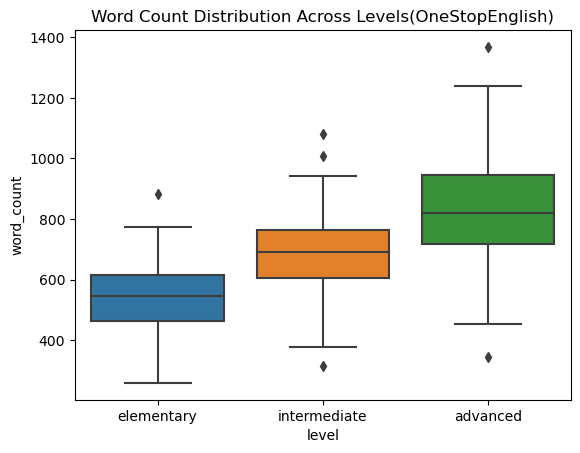

In [48]:
# Compare average text length across levels

# Compute word counts for each text
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

# Summary statistics
print(df.groupby("level")["word_count"].describe())


order = ["elementary", "intermediate", "advanced"]
sns.boxplot(data=df, x="level", y="word_count", order=order)
plt.title("Word Count Distribution Across Levels(OneStopEnglish)")
plt.show()


Average word counts increase with text level, from ~534 words at elementary to ~678 at intermediate and ~825 at advanced. This confirms that text complexity in the dataset scales as expected, with advanced articles consistently longer and more detailed than lower-level ones.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niloofarkarimi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


=== Unique Words by Level ===
              count        mean        std    min    25%    50%    75%    max
level                                                                        
advanced      189.0  433.862434  76.858686  202.0  381.0  434.0  489.0  667.0
elementary    189.0  279.216931  47.942569  147.0  245.0  279.0  316.0  416.0
intermediate  189.0  351.275132  53.735844  185.0  318.0  349.0  391.0  528.0

=== Avg Sentence Length by Level ===
              count       mean       std        min        25%        50%  \
level                                                                       
advanced      189.0  28.838361  5.051631  17.657534  25.156250  28.666667   
elementary    189.0  21.638915  3.242707  13.875000  19.656250  21.583333   
intermediate  189.0  22.170063  3.019545  14.806452  20.210526  22.111111   

                    75%        max  
level                               
advanced      32.250000  53.411765  
elementary    23.068966  39.700000  
intermed

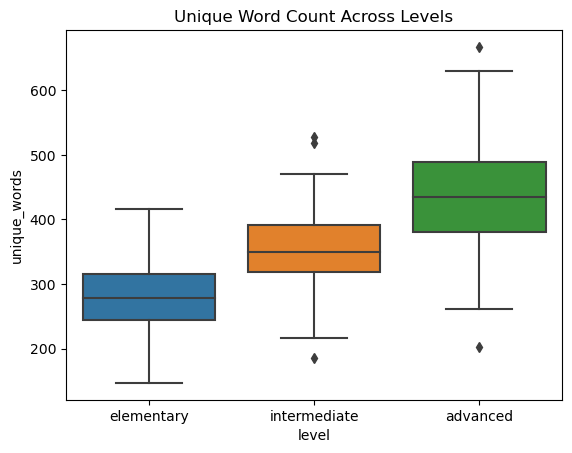

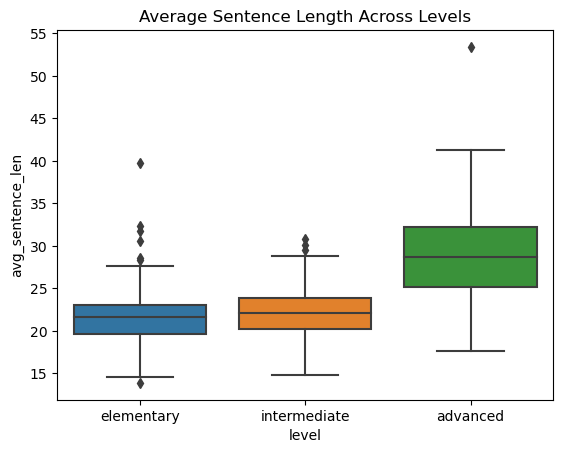

In [21]:
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize

# Compute unique word count
df["unique_words"] = df["text"].apply(lambda x: len(set(x.lower().split())))

# Compute avg sentence length
def avg_sentence_length(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    return len(words) / len(sentences) if len(sentences) > 0 else 0

df["avg_sentence_len"] = df["text"].apply(avg_sentence_length)

# Summary statistics by level
print("=== Unique Words by Level ===")
print(df.groupby("level")["unique_words"].describe())

print("\n=== Avg Sentence Length by Level ===")
print(df.groupby("level")["avg_sentence_len"].describe())

# Plot unique words
sns.boxplot(data=df, x="level", y="unique_words", order=["elementary","intermediate","advanced"])
plt.title("Unique Word Count Across Levels")
plt.show()

# Plot sentence length
sns.boxplot(data=df, x="level", y="avg_sentence_len", order=["elementary","intermediate","advanced"])
plt.title("Average Sentence Length Across Levels")
plt.show()


               fk_grade       smog
level                             
advanced      11.261761  13.049428
elementary     8.397635  10.989847
intermediate  10.080939  12.238161


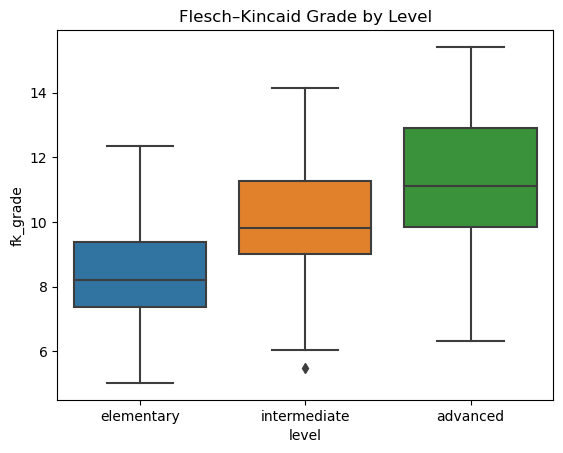

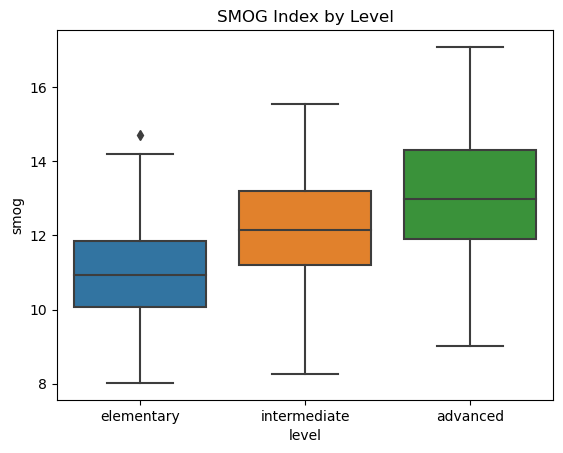

In [25]:
# Readability Metrics Across Levels
#Show that Flesch–Kincaid Grade Level (FKGL) and SMOG increase with text level.

# !pip install textstat

import textstat

df["fk_grade"] = df["text"].apply(textstat.flesch_kincaid_grade)
df["smog"] = df["text"].apply(textstat.smog_index)

print(df.groupby("level")[["fk_grade","smog"]].mean())

sns.boxplot(data=df, x="level", y="fk_grade", order=["elementary","intermediate","advanced"])
plt.title("Flesch–Kincaid Grade by Level"); plt.show()

sns.boxplot(data=df, x="level", y="smog", order=["elementary","intermediate","advanced"])
plt.title("SMOG Index by Level"); plt.show()



Flesch–Kincaid Grade Level (FKGL): The FKGL scores increase from elementary (~8.4) to intermediate (~10.1) to advanced (~11.3), showing that texts at higher levels require progressively more years of education to comprehend.

SMOG Index: Similarly, SMOG scores rise from ~10.1 (elementary) to ~12.2 (intermediate) to ~13.0 (advanced), confirming that advanced texts demand greater reading proficiency due to longer sentences and more polysyllabic words.

This confirms that the dataset’s readability levels are aligned with the intended difficulty progression.

In [26]:
# Topic Preservation Across Levels
# Check if articles across levels talk about the same topics. For example, use TF-IDF + cosine similarity.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# pick one story aligned across levels
sample_id = 10
texts = df.iloc[sample_id:sample_id+3]["text"].tolist()
levels = df.iloc[sample_id:sample_id+3]["level"].tolist()

vectorizer = TfidfVectorizer(stop_words="english")
tfidf = vectorizer.fit_transform(texts)

sim_matrix = cosine_similarity(tfidf)
print("Cosine similarity between levels:", sim_matrix)



Cosine similarity between levels: [[1.         0.02162675 0.05017588]
 [0.02162675 1.         0.02338966]
 [0.05017588 0.02338966 1.        ]]


In [27]:
# Word Frequency Differences
# Compare which words are most frequent at each level.

from collections import Counter
import re

def get_top_words(level, n=10):
    texts = " ".join(df[df["level"]==level]["text"].tolist()).lower()
    words = re.findall(r"\b[a-z]+\b", texts)
    return Counter(words).most_common(n)

print("Elementary top words:", get_top_words("elementary"))
print("Intermediate top words:", get_top_words("intermediate"))
print("Advanced top words:", get_top_words("advanced"))


Elementary top words: [('the', 6118), ('and', 2579), ('to', 2568), ('of', 2466), ('a', 2328), ('in', 2283), ('that', 1483), ('is', 1337), ('it', 1098), ('for', 915)]
Intermediate top words: [('the', 7786), ('of', 3581), ('to', 3489), ('and', 3324), ('a', 3132), ('in', 2824), ('that', 1707), ('is', 1646), ('for', 1205), ('it', 1111)]
Advanced top words: [('the', 9573), ('of', 4560), ('to', 4442), ('and', 3988), ('a', 3915), ('in', 3441), ('that', 1936), ('is', 1840), ('it', 1562), ('for', 1474)]


### Alignment Check

In [34]:
n = 189  # number of samples per level
df["article_id"] = df.index % n


for i in range(3):  # check first 3 aligned groups
    print(f"\n=== ARTICLE {i} ===")
    print(df[df["article_id"] == i][["level","text"]])



=== ARTICLE 0 ===
            level                                               text
0      elementary  When you see the word Amazon, what’s the first...
189  intermediate  Intermediate\nWhen you see the word Amazon, wh...
378      advanced  When you see the word Amazon, what’s the first...

=== ARTICLE 1 ===
            level                                               text
1      elementary  To tourists, Amsterdam still seems very libera...
190  intermediate  Intermediate\nTo tourists, Amsterdam still see...
379      advanced  Amsterdam still looks liberal to tourists, who...

=== ARTICLE 2 ===
            level                                               text
2      elementary  Anitta, a music star from Brazil, has millions...
191  intermediate  Intermediate\nBrazils latest funk sensation, A...
380      advanced  Brazil’s latest funk sensation, Anitta, has wo...


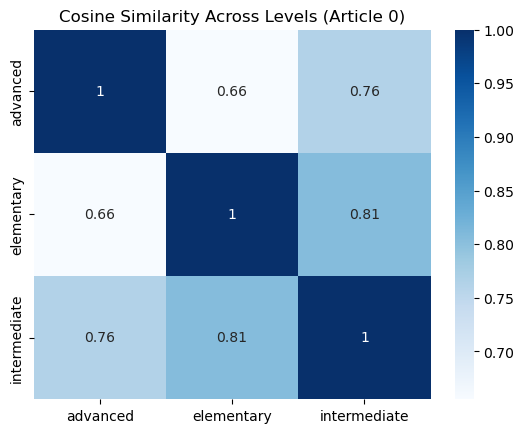

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Pick an aligned article (e.g., id=0)
article_id = 0
subset = df[df["article_id"] == article_id].sort_values("level")

texts = subset["text"].tolist()
levels = subset["level"].tolist()

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english")
tfidf = vectorizer.fit_transform(texts)

# Cosine similarity matrix
sim_matrix = cosine_similarity(tfidf)

# Heatmap
sns.heatmap(sim_matrix, annot=True, xticklabels=levels, yticklabels=levels, cmap="Blues")
plt.title(f"Cosine Similarity Across Levels (Article {article_id})")
plt.show()


This cosine similarity heatmap shows how closely aligned the three difficulty versions of Article 0 are:

The elementary–intermediate pair has the highest similarity (0.81), suggesting intermediate texts are mostly simplified extensions of elementary ones.

The advanced–elementary pair is the least similar (0.66), which makes sense since advanced texts introduce more complex vocabulary and sentence structures.

The advanced–intermediate pair sits in between (0.76), reflecting that intermediate texts bridge the gap between simple and advanced language.

The alignment check works — each version covers the same content, but increasing levels show progressively more linguistic complexity, exactly as intended in the dataset design.

# CLEAR Corpus:

In [49]:
from datasets import load_dataset

# Load CommonLit Ease of Readability
ds = load_dataset("casey-martin/CommonLit-Ease-of-Readability")
df = pd.DataFrame(ds["train"])

# Preview
print(df.head(5)[["Excerpt", "Flesch-Reading-Ease", "Flesch-Kincaid-Grade-Level", "SMOG Readability"]])

                                             Excerpt  Flesch-Reading-Ease  \
0  Words alone are not a sufficient possession. T...                53.14   
1  The true use of the much-praised Lucius Cary, ...                63.37   
2  Once, when I was returning from a hunt, with a...                82.12   
3  Vesuvius is a dangerous thing, but very beauti...                88.10   
4  Viscosity is a physical property of fluids. It...                67.28   

   Flesch-Kincaid-Grade-Level  SMOG Readability  
0                       11.87              13.0  
1                        9.89              12.0  
2                        7.48               9.0  
3                        3.19               8.0  
4                        7.23               9.0  


The CLEAR corpus provides text excerpts paired with multiple readability metrics such as Flesch Reading Ease, Flesch–Kincaid Grade Level, and SMOG Index. The sample shows a wide spread of scores (e.g., Flesch–Kincaid from 3.19 to 11.87), confirming that the dataset covers passages appropriate for different reading levels and is suitable for training models on readability prediction.

/Users/niloofarkarimi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niloofarkarimi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niloofarkarimi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


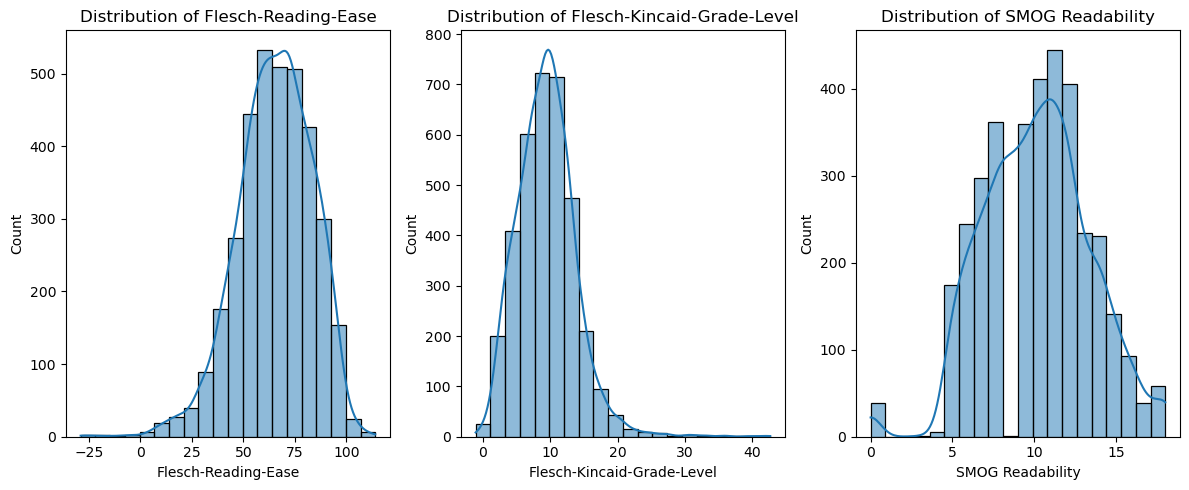

In [50]:
# Distribution of Readability Scores

scores = ["Flesch-Reading-Ease", "Flesch-Kincaid-Grade-Level", "SMOG Readability"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(scores, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


The distributions confirm that the dataset spans a wide range of reading difficulties. Flesch Reading Ease is centered around 60–70 (moderately difficult texts), while Flesch–Kincaid Grade Levels cluster around 8–12, reflecting middle to high school readability. SMOG scores are similarly concentrated around 10–13, further validating the dataset’s suitability for studying nuanced readability variation.

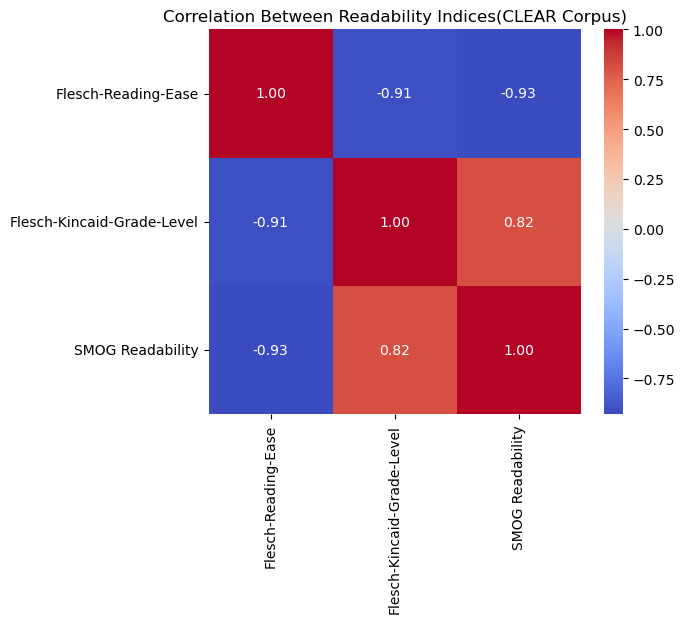

In [51]:
# Correlation Between Readability Metrics

plt.figure(figsize=(6,5))
sns.heatmap(df[scores].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Readability Indices(CLEAR Corpus)")
plt.show()


The correlation heatmap shows strong consistency across metrics: Flesch Reading Ease is strongly negatively correlated with both Flesch–Kincaid (−0.91) and SMOG (−0.93), while Flesch–Kincaid and SMOG are positively correlated (0.82), confirming they capture similar aspects of text difficulty.


In [43]:
# Extreme Case Samples

easy = df.nsmallest(1, "Flesch-Kincaid-Grade-Level")[["Excerpt", "Flesch-Kincaid-Grade-Level"]]
hard = df.nlargest(1, "Flesch-Kincaid-Grade-Level")[["Excerpt", "Flesch-Kincaid-Grade-Level"]]

print("=== Easiest Sample ===")
print(easy.values)

print("\n=== Hardest Sample ===")
print(hard.values)


=== Easiest Sample ===
[['Cat and Dog open the door. They open the door of their house. Cat and Dog leave their house. Cat and Dog walk. They walk on the grass. They walk between the trees. They walk through the bush. Then they stop. Cat and Dog see a sign. They see a sign on a tree. Cat and Dog look at the sign. They look at the words on the sign. Cat and Dog read. They read the sign, \'look out for the cape.\' Cat says, "What is a cape?" Dog says, "A cape is a jacket. Cat and Dog cannot see a cape. Then they laugh. They laugh at the sign. They laugh at the silly sign. But then the words change! Cat and Dog read. They read the sign. \'Look out for the grape.\' Cat says, "What is a grape?" Dog says, "A grape is a fruit." Cat and Dog cannot see a grape. Then they laugh. They laugh at the sign. They laugh at the silly sign.'
  -1.04]]

=== Hardest Sample ===
[['It is further agreed by the parties hereto, that said Indians will be permitted to select their farms and homes on a tract of la

The easiest text is a simple, repetitive children’s story about Cat and Dog with a Flesch–Kincaid grade level of 1.04, while the hardest text is a dense legal passage about Native American land agreements with a grade level of 42.64, highlighting the dataset’s wide range of readability levels.
